# **Interpretable ebm**

In [384]:
import pandas as pd
import numpy as np
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt
from interpret import show
from sklearn.linear_model import LinearRegression


#### **data**

In [385]:
training_set = pd.read_csv('../dataset/standardized_training.csv')
X_train = training_set.drop('general_two_year', axis=1)
y_train = training_set['general_two_year']

test_set = pd.read_csv('../dataset/standardized_testing.csv')
X_test = test_set.drop('general_two_year', axis=1)
y_test = test_set['general_two_year'].values

#### **hyperparameter tuning**

In [388]:
#hyperparameter tuning 
ebm = ExplainableBoostingClassifier(random_state=42, n_jobs=-1)
ebm_param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01,0.1],
    'early_stopping_rounds':[2,5,10,50],
    'max_rounds':[10,100,1000,10000],
    'max_bins': [32,64,128, 256,512],
    'max_interaction_bins': [16, 32,64],
    'interactions': [2],
    'min_samples_leaf': [1,10,50]
}

ebm_grid_search = GridSearchCV(estimator=ebm, param_grid=ebm_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
ebm_grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", ebm_grid_search.best_params_)



Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'early_stopping_rounds': 50, 'interactions': 2, 'learning_rate': 0.01, 'max_bins': 32, 'max_interaction_bins': 64, 'max_rounds': 1000, 'min_samples_leaf': 1}


In [389]:
#best ebm:
best_ebm = ExplainableBoostingClassifier(**ebm_grid_search.best_params_)
best_ebm.fit(X_train, y_train)
best_ebm_pred = best_ebm.predict(X_test)



print("EBM")
print("Best Hyperparameters:", ebm_grid_search.best_params_)
print("accuracy:\t",accuracy_score(y_test, best_ebm_pred))
print("precision:\t", precision_score(y_test, best_ebm_pred))



EBM
Best Hyperparameters: {'early_stopping_rounds': 50, 'interactions': 2, 'learning_rate': 0.01, 'max_bins': 32, 'max_interaction_bins': 64, 'max_rounds': 1000, 'min_samples_leaf': 1}
accuracy:	 0.649616368286445
precision:	 0.6083916083916084


In [390]:
global_explanation = best_ebm.explain_global()

show(global_explanation)

c:\Users\lnick\AppData\Local\Programs\Python\Python311\Lib\site-packages\interpret\visual\_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/2702777792848/ -->

In [391]:
features_data = []

for feature_index in range(len(global_explanation.feature_names)):
    feature_name = global_explanation.feature_names[feature_index]
    feature_data = global_explanation.data(feature_index)

    # Store the data for later use
    features_data.append((feature_name, feature_data))


In [392]:
feature_names = global_explanation.data()['names']
feature_scores = global_explanation.data()['scores']

# Initialize a dictionary to store feature importances
feature_importances = {}

# Calculate importance for each feature
for feature, scores in zip(feature_names, feature_scores):
    importance = abs(scores)
    feature_importances[feature] = importance

# Sort the features based on importance
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

total_importance = sum(score for feature, score in sorted_features)

# Total points for the scorecard, e.g., 100
total_points = 100

# Normalization factor
normalization_factor = total_importance / total_points

# Normalize each feature's score
normalized_scores = [(feature, score / normalization_factor) for feature, score in sorted_features]


# Set of feature names with high scores
high_score_feature_names = {feature for feature, score in normalized_scores}


In [393]:
# Filter features_data to include only features with high scores
features_data = [(feature_name, feature_data) for feature_name, feature_data in features_data if feature_name in high_score_feature_names]


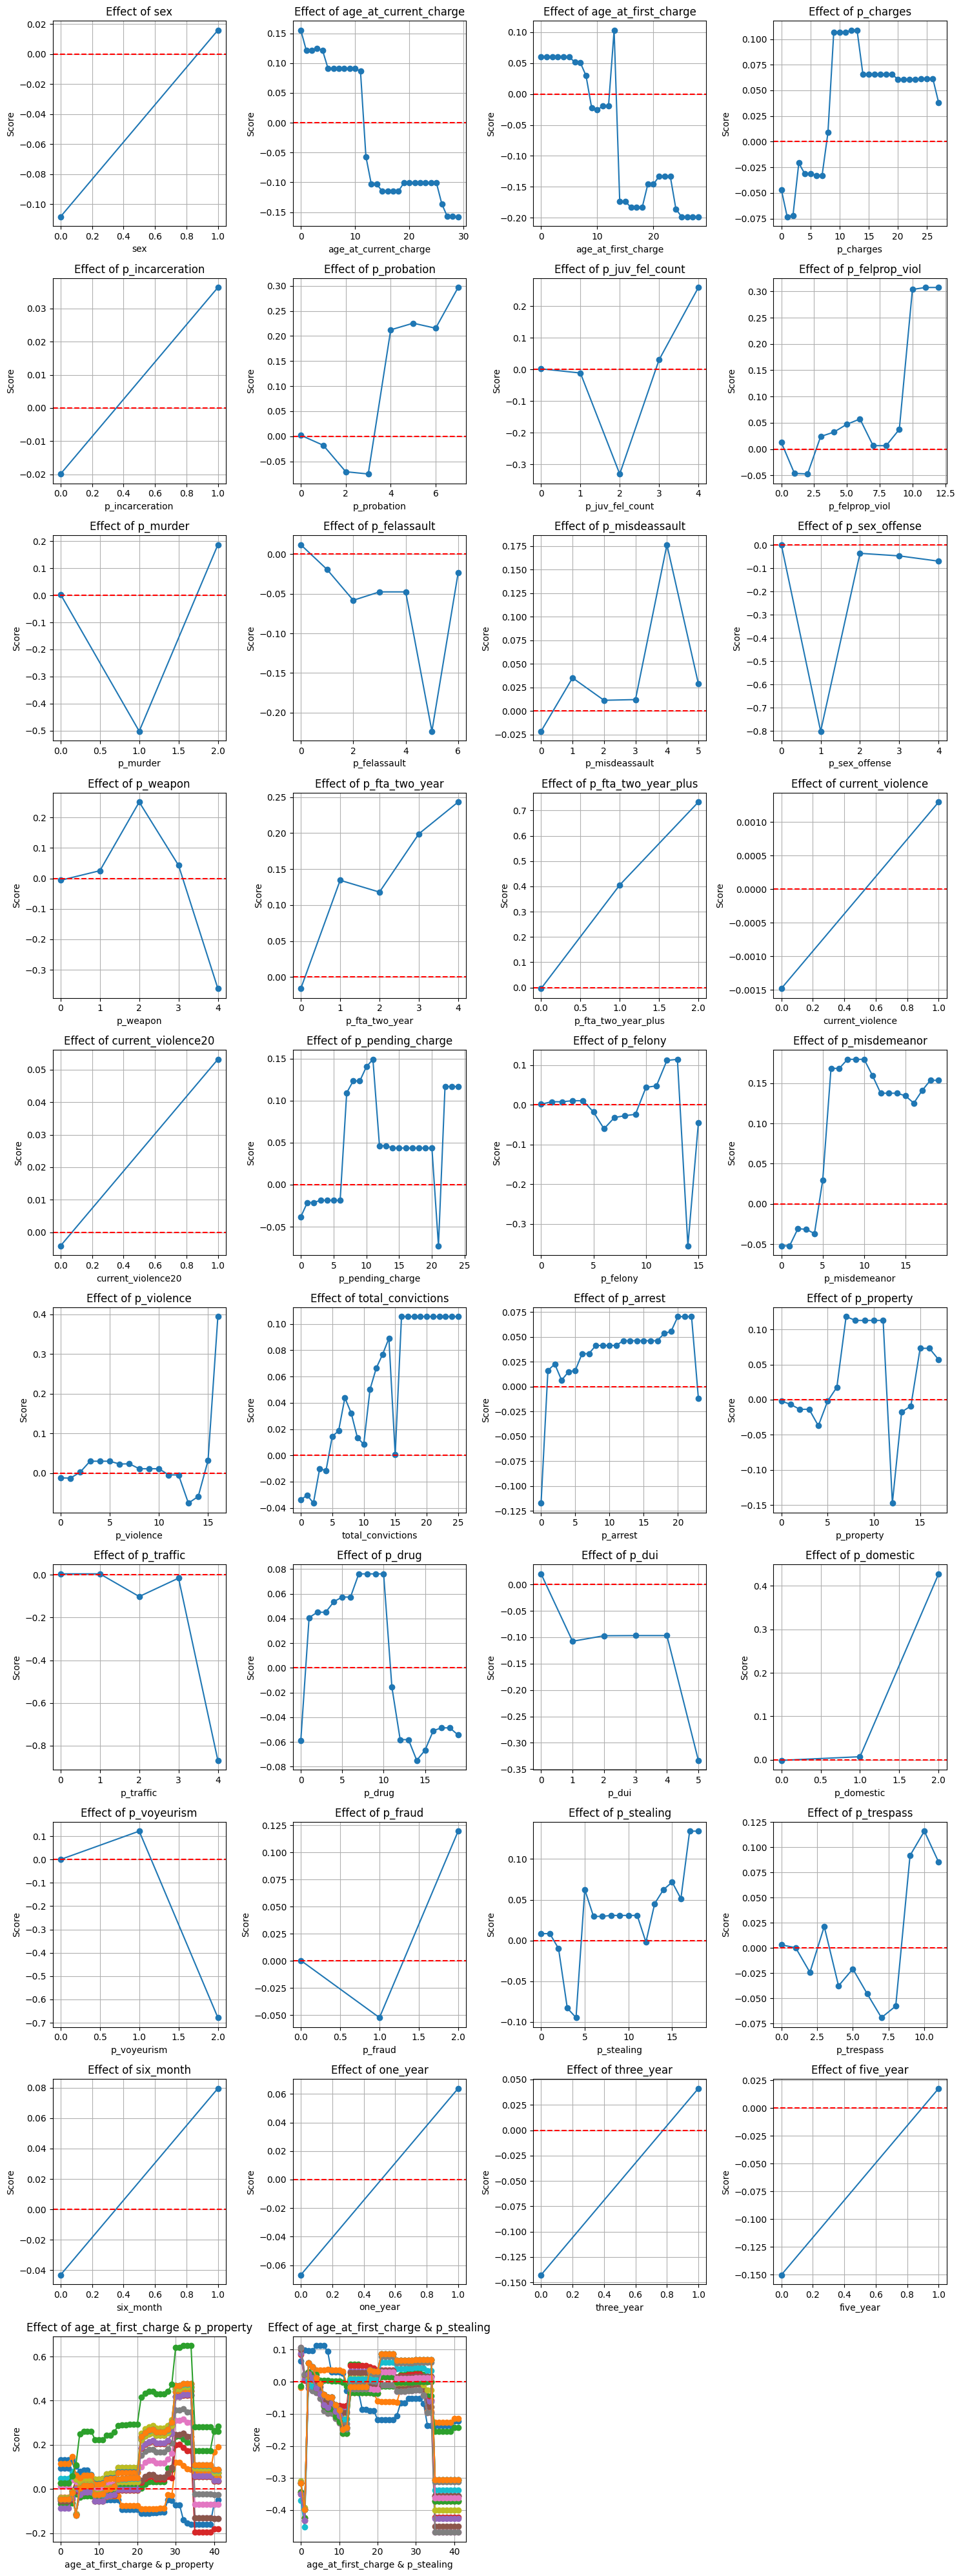

In [394]:

# Number of features
num_features = len(global_explanation.feature_names)

# Define the layout of the subplots
num_rows = 10  # Adjust as necessary
num_cols = (num_features + 9) // num_rows

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 40))  # Adjust the figure size as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

window_size = 5 # adjust as needed

for i, (feature_name, feature_data) in enumerate(features_data):
    ax = axes[i]
    
    # Assuming feature_data contains 'scores' and corresponding 'values'
    scores = feature_data['scores'] if 'scores' in feature_data else []
    values = feature_data['values'] if 'values' in feature_data else range(len(scores))

    # Plot the feature effect
    ax.plot(values, scores, marker='o')

    ax.axhline(y=0, color='red', linestyle='--')

    ax.set_title(f"Effect of {feature_name}")
    ax.set_xlabel(feature_name)
    ax.set_ylabel('Score')
    ax.grid(True)

for j in range(i + 1, num_rows * num_cols):
    axes[j].set_visible(False)
    
# Adjust layout
plt.tight_layout()
plt.show()

In [396]:
feature_split_list = []

# Filter features_data to include only features with high scores
features_data = [(feature_name, feature_data) for feature_name, feature_data in features_data if feature_name in high_score_feature_names]

for feature_name, feature_data in features_data:
   
    scores = feature_data['scores'] if 'scores' in feature_data else []
    values = feature_data['values'] if 'values' in feature_data else range(len(scores))
    scores = np.array(scores)

    # Find the split index where the score changes sign
    split_index = []
    for i in range(1, len(scores)):  # Start from 1 to avoid index -1
        if not isinstance(scores[i], np.ndarray):
            if scores[i] * scores[i - 1] < 0:
                split_index.append(i)
    
    positive_above_split = []
    # If a split point is found, determine the value and the indicator
    for split in split_index:
        split_value = values[split]
        sign = scores[split] > 0
        positive_above_split.append(sign)

    print(split_index)
    print(positive_above_split)
        
    feature_split_list.append((feature_name, split_index, positive_above_split))


[1]
[True]
[12]
[False]
[9, 13, 14]
[False, True, False]
[8]
[True]
[1]
[True]
[1, 4]
[False, True]
[1, 3]
[False, True]
[1, 3]
[False, True]
[1, 2]
[False, True]
[1]
[False]
[1]
[True]
[1]
[False]
[1, 4]
[True, False]
[1]
[True]
[1]
[True]
[1]
[True]
[1]
[True]
[7, 21, 22]
[True, False, True]
[5, 10, 14]
[False, True, False]
[5]
[True]
[2, 11, 15]
[True, False, True]
[5]
[True]
[1, 23]
[True, False]
[6, 12, 15]
[True, False, True]
[2]
[False]
[1, 11]
[True, False]
[1]
[False]
[1]
[True]
[2]
[False]
[1, 2]
[False, True]
[2, 5, 12, 13]
[False, True, False, True]
[2, 3, 4, 9]
[False, True, False, True]
[1]
[True]
[1]
[True]
[1]
[True]
[1]
[True]
[]
[]
[]
[]


In [397]:
for feature_info in feature_split_list:
    feature_name, split_value, positive_above_split = feature_info
    indicator = 'Positive' if positive_above_split else 'Negative'
    print(f"Feature: {feature_name}\nSplit Value: {split_value}\nIndicator: {indicator} at or above split\n\n")


Feature: sex
Split Value: [1]
Indicator: Positive at or above split


Feature: age_at_current_charge
Split Value: [12]
Indicator: Positive at or above split


Feature: age_at_first_charge
Split Value: [9, 13, 14]
Indicator: Positive at or above split


Feature: p_charges
Split Value: [8]
Indicator: Positive at or above split


Feature: p_incarceration
Split Value: [1]
Indicator: Positive at or above split


Feature: p_probation
Split Value: [1, 4]
Indicator: Positive at or above split


Feature: p_juv_fel_count
Split Value: [1, 3]
Indicator: Positive at or above split


Feature: p_felprop_viol
Split Value: [1, 3]
Indicator: Positive at or above split


Feature: p_murder
Split Value: [1, 2]
Indicator: Positive at or above split


Feature: p_felassault
Split Value: [1]
Indicator: Positive at or above split


Feature: p_misdeassault
Split Value: [1]
Indicator: Positive at or above split


Feature: p_sex_offense
Split Value: [1]
Indicator: Positive at or above split


Feature: p_weapon
Spl

**allocate points**

In [398]:
feature_points = []

for feature_info in feature_split_list:
    feature_name, split_value, positive_above_split = feature_info
    points=[]
    
    for name, value in normalized_scores:
        if name == feature_name:
            for sign in positive_above_split:
                if sign:
                    points.append(value)
                else:
                    points.append(-value)

    feature_points.append((feature_name,split_value,points))

print(feature_points)

[('sex', [1], [2.358975746938124]), ('age_at_current_charge', [12], [-9.456602657208517]), ('age_at_first_charge', [9, 13, 14], [-6.783208831780829, 6.783208831780829, -6.783208831780829]), ('p_charges', [8], [4.660862008595607]), ('p_incarceration', [1], [2.1939214404403775]), ('p_probation', [1, 4], [-2.72972226361701, 2.72972226361701]), ('p_juv_fel_count', [1, 3], [-0.6118311828841371, 0.6118311828841371]), ('p_felprop_viol', [1, 3], [-2.3486578982335122, 2.3486578982335122]), ('p_murder', [1, 2], [-0.7137581467417664, 0.7137581467417664]), ('p_felassault', [1], [-1.5181237624499444]), ('p_misdeassault', [1], [2.1988182194937766]), ('p_sex_offense', [1], [-0.30334009905692716]), ('p_weapon', [1, 4], [1.3284840012917791, -1.3284840012917791]), ('p_fta_two_year', [1], [2.4729278276432605]), ('p_fta_two_year_plus', [1], [0.6480786305895765]), ('current_violence', [1], [0.11792762097358339]), ('current_violence20', [1], [0.6566547566509046]), ('p_pending_charge', [7, 21, 22], [3.761478

assign everyone in the training set a score, based on the scorecard

In [399]:
scores = []

for _, person in X_train.iterrows():
    score = 0

    for scorecard in feature_points:
        feature_name, split_value,points = scorecard

        for i,value in enumerate(split_value):
            if person[feature_name]>=value:
                if i==len(split_value)-1:
                    score -= points[i]
                else:
                    i=i
            else:
                score += points[i]


    scores.append(score)
print(scores)

[18.219841732544626, 15.432660288172379, 29.033674028651006, 26.303951765034, 26.303951765034, 21.906315326046446, 14.605811713298547, 15.656943715564914, 11.800114146187665, 22.51814650893058, 24.952356409053134, 6.362840641160394, 12.358126920593435, 26.303951765034, 17.781619983684244, 33.65460294435158, 21.916108884153246, 7.412271265306911, 26.303951765034, 26.303951765034, 26.303951765034, 22.60768461342538, 24.99064225173219, 26.303951765034, 24.636037589663456, 12.358126920593435, 17.762881350768236, 16.74596980147419, 9.868238457074087, 26.303951765034, 16.906532219242816, 16.74596980147419, 16.74596980147419, 5.675535806600497, 4.497637037610032, 12.96995810347757, 26.303951765034, 21.916108884153246, 12.572616789879167, 14.54479338872901, 16.74596980147419, 22.52794006703738, 26.303951765034, 11.800114146187665, 26.303951765034, 21.401166500445463, 25.257662330654394, -0.311210298173044, 21.916108884153246, 26.303951765034, 21.35809610974748, 21.2792006121336, 14.70678481882

**use regression analysis to decide how to correlate scores to labels**

In [401]:
scores=np.array(scores).reshape(-1, 1)

regressor = LinearRegression()
regressor.fit(scores, y_train)

y_pred = regressor.predict(scores)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Initialize variables to store the best threshold and corresponding metric
best_threshold = None
best_metric = 0.0  # You can use accuracy, precision, recall, F1-score, etc.

# Iterate through the thresholds
for threshold in thresholds:
    # Apply the threshold to get binary predictions
    binary_predictions = [1 if y >= threshold else 0 for y in y_pred]

    # Calculate the desired metric (e.g., accuracy)
    metric = accuracy_score(y_train, binary_predictions)

    # Update best_threshold and best_metric if the current threshold is better
    if metric > best_metric:
        best_threshold = threshold
        best_metric = metric

print(best_threshold)
print(best_metric)

0.5
0.58680333119795
